### Environment
Python 3.7 x64

### Demo
todo

### Questions
- 1 这首诗美吗
- 2 这首诗顺口吗
- 3 这首诗触动了你吗
- 4 这首诗有意义吗
- 5 你愿意给这首诗打多少赏


# Load

In [6]:
%pylab inline
import seaborn as sns
import pandas as pd

# # Load raw data
# report = pd.read_csv('report_crowds.csv',header=None)
# # Naming the columns
# report.columns = ['id', 'poem', 'subject', 'score_1', 'score_2', 'score_3', 'score_4', 'score_5','rt']


# '''Reformat'''
# rts = report['rt'].apply(lambda x: dict((i[1], int(i[3:]))
#                                      for i in x.split(' ') if i[3:] != ''))  # Get a dict of RTs
# for i in range(1, 6):
#     # Add a column of RT for each question
#     report['rt_' + str(i)] = rts.apply(lambda x: x[str(i)])

# del report['rt']
# del report['id']

report = pd.read_csv('report_crowds_raw.csv')
report.head()

Populating the interactive namespace from numpy and matplotlib


,poem,subject,score_1,score_2,score_3,score_4,score_5,rt_1,rt_2,rt_3,rt_4,rt_5
0,147,12,3,3,4,4,4,1732,1916,15132,1585,2594
1,16,12,5,3,5,4,5,1316,7062,6214,1464,1220
2,65,12,3,3,5,4,4,2163,1233,1835,10507,1996
3,92,12,3,3,3,2,2,1362,1154,7783,1466,1718
4,56,29,8,9,8,8,9,19760,13651,13578,5705,2309


# Preprocessing
(Note: a "record" refers to a poem done by a subject, an "item" refers to a rating result on a question done by a subject)

In [17]:
'''"report_filt" is created for store the filtered data'''
# ".copy()" makes sure that the change to "report2" won't influence "report"
report_filt = report.copy()

'''[Step1] Filter the row whose scores on 5 questions are equal'''
keep = report_filt.apply(lambda x:
                         not (x['score_1'] == x['score_2'] and x['score_2'] == x['score_3'] and x['score_3'] == x['score_4'] and x['score_4'] == x['score_5']), axis=1)
report_filt = report_filt[keep == True]
print('Remained records: %d in %d' % (len(report_filt), len(keep)))


'''[Step2] Filter the record whose RT is out of range (let it NA)'''
# Store all the RT in a list
RTs = []
for ind, rts in report_filt[['rt_1', 'rt_2', 'rt_3', 'rt_4', 'rt_5']].iterrows():
    for rt in rts:
        RTs.append(rt)

# Calculate the 5% boundary of RT
order_RTs = sorted(RTs)
limit = int(len(order_RTs) * 0.05)  # the position of 5%
lower, upper = order_RTs[limit], order_RTs[-limit]
print('lower:%d, upper:%d' % (lower, upper))

# Filter the out-of-range RTs
report_filt2 = report_filt[['poem', 'subject']]
rt_count_all, rt_count_filtered = 0, 0
for i in range(1, 6):  # Filter on each question
    score_q, rt_q = 'score_' + str(i), 'rt_' + str(i)
    filtered = report_filt.loc[report_filt[rt_q].isin(range(lower, upper)), 
                                [score_q, rt_q]]
    report_filt2 = report_filt2.join(filtered)

    rt_count_filtered += len(filtered)
    rt_count_all += len(report_filt2)

print('Remained items: %d in %d' % (rt_count_filtered, rt_count_all))
report_filt = report_filt2

# poem_count = report_filt.groupby('poem').apply(lambda x:len(x)).sort_values()
# print(f'answers count ranges from {poem_count.min()} to {poem_count.max()}')

filtered_count = []
for p_ind,p_data in report_filt.groupby('poem'):
#     print(p_ind)
    for i in range(1, 6):  # Filter on each question
        score_q = 'score_' + str(i)
        filtered_count.append(len(p_data[~p_data[score_q].isnull()]))
#         print(len(p_data[p_data[score_q].isnull()])/len(p_data))
print(f'Answers count for each poem/question --  min:{min(filtered_count)}, max:{max(filtered_count)}, avg:{np.mean(filtered_count)}')

'''Display'''
report_filt.head()

Remained records: 12421 in 15283
lower:429, upper:17299
Remained items: 55902 in 62105
Answers count for each poem/question --  min:53, max:109, avg:74.536


,poem,subject,score_1,rt_1,score_2,rt_2,score_3,rt_3,score_4,rt_4,score_5,rt_5
0,147,12,3.0,1732.0,3.0,1916.0,4.0,15132.0,4.0,1585.0,4.0,2594.0
1,16,12,5.0,1316.0,3.0,7062.0,5.0,6214.0,4.0,1464.0,5.0,1220.0
2,65,12,3.0,2163.0,3.0,1233.0,5.0,1835.0,4.0,10507.0,4.0,1996.0
3,92,12,3.0,1362.0,3.0,1154.0,3.0,7783.0,2.0,1466.0,2.0,1718.0
4,56,29,NaN,NaN,9.0,13651.0,8.0,13578.0,8.0,5705.0,9.0,2309.0


In [129]:
report_filt.to_csv('report_crowds_filtered.csv')

# Plot

0 3757
1 3928
2 5526
3 7314
4 7227
5 8288
6 7582
7 5993
8 3849
9 2438


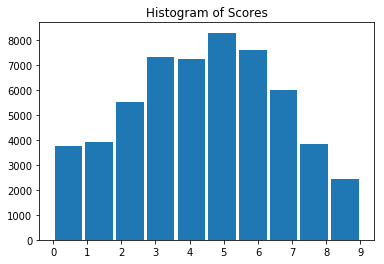

In [108]:
'''score dist (filtered data)'''
scores = []
for i in range(1,6):
    for ind,row in report_filt.iterrows():
        score_t = row[f'score_{i}']
        if not np.isnan(score_t):
            scores.append(score_t)
            
scores = np.array(scores)
for i in range(10):
    print(i,sum(scores==i))
    
plt.hist(scores, bins=10,rwidth=0.9)  # arguments are passed to np.histogram
plt.title("Histogram of Scores")
plt.xticks(np.arange(10), [str(i) for i in range(10)])
plt.show()

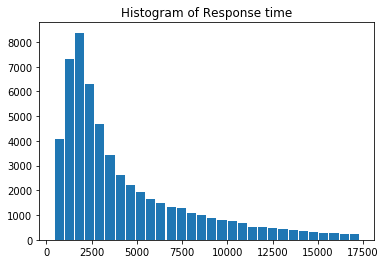

In [28]:
'''RT dist (filtered data)'''
filtered_RTs = order_RTs[limit:-limit]

plt.hist(filtered_RTs,bins=30,rwidth=0.9)  # arguments are passed to np.histogram
plt.title("Histogram of Response time")
plt.show()

Q1 std: 2.39470992416404


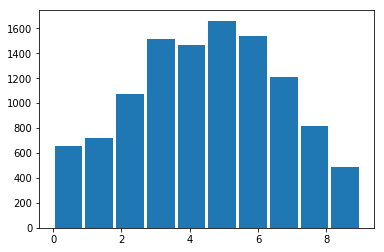

Q2 std: 2.431138831812719


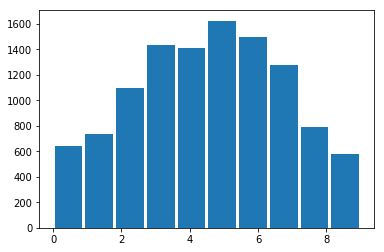

Q3 std: 2.477334014549428


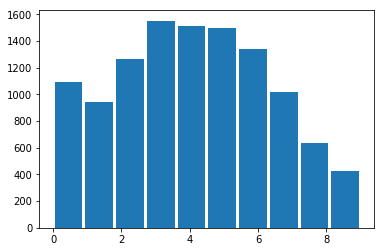

Q4 std: 2.3805371872971537


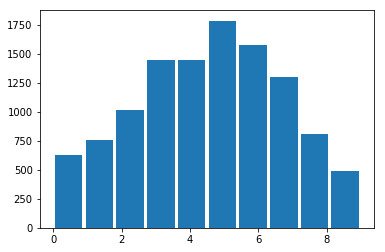

Q5 std: 2.422342853763051


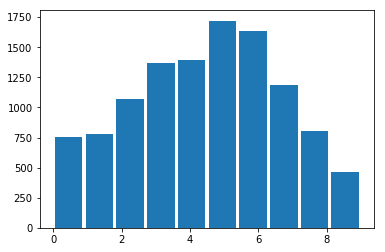

In [113]:
'''score dist on each question'''
for i in range(1,6):
    report_t = report_filt['score_%d' %i]
    report_t = report_t[~report_t.isnull()]
    print(f'Q{i} std: {np.std(report_t)}')
    plt.hist(report_t,bins=10,rwidth=0.9)
#     sns.distplot(report_t,bins=20)
    plt.show()


# Correlation

In [66]:
'''average value for each poem (150*5)'''
score_mat = report_filt.groupby('poem').mean()[[f'score_{i}' for i in range(1,6)]]
score_mat

,score_1,score_2,score_3,score_4,score_5
poem,,,,,
1,4.512821,4.526316,3.697368,4.443038,4.278481
2,4.540541,4.539474,3.621622,4.351351,4.253521
3,4.542857,4.328767,3.594595,4.171429,4.114286
4,5.287879,5.727273,4.541667,5.333333,5.323944
5,5.253968,4.761905,5.000000,5.161765,5.045455
6,5.437500,5.493506,4.714286,5.135135,5.500000
7,5.223684,5.230769,4.426667,4.666667,5.025316
8,4.205128,5.096386,3.728395,4.452381,4.301205
9,4.616279,4.795181,3.988372,4.298851,4.511905


In [87]:
'''Pearson Correlation matrix (raw)'''
score_corr_mat = score_mat.corr()
for i in range(5):
    for j in range(5):
        if i<=j:
            score_corr_mat.iloc[i,j] = 0
#         else:
#             score_corr_mat.iloc[i,j] -= 0.5
score_corr_mat

,score_1,score_2,score_3,score_4,score_5
score_1,0.000000,0.000000,0.000000,0.000000,0.0
score_2,0.665048,0.000000,0.000000,0.000000,0.0
score_3,0.789467,0.640654,0.000000,0.000000,0.0
score_4,0.622269,0.540398,0.827463,0.000000,0.0
score_5,0.848539,0.731010,0.852156,0.765346,0.0


In [128]:
'''Correlation matrix (shuffled)'''
# 1000 matrix of shuffled data
corr_mat_shuffled = []
score_mat_val = score_mat.values.T
for _ in range(1000):
    corr_mat_shuffled.append(np.corrcoef(np.array([numpy.random.permutation(score_mat_val[i]) for i in range(5)])))

# matrix with 97.5% values
corr_mat_signif_shuffled = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        if i<=j:
            corr_val_shuffled = [corr_mat_shuffled[k][i,j] for k in range(1000)]
            corr_mat_signif_shuffled[i,j] = np.sort(corr_val_shuffled)[975]
            
corr_mat_signif_shuffled.T

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.16367972, 1.        , 0.        , 0.        , 0.        ],
       [0.16462723, 0.15144547, 1.        , 0.        , 0.        ],
       [0.15653863, 0.14926069, 0.16395774, 1.        , 0.        ],
       [0.17684771, 0.15779004, 0.16643529, 0.15263168, 1.        ]])

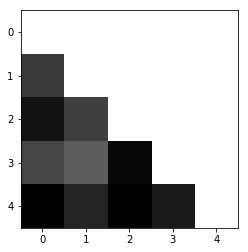

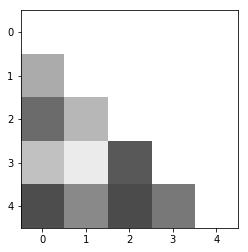

In [106]:
'''Correlation matrix plot'''
# real values
plt.imshow(1-score_corr_mat, cmap=cm.gray)
plt.show()

# values - 0.5
plt.imshow(1-score_corr_mat, cmap=cm.gray, vmin=0, vmax=0.5)
plt.show()

#  Another format: multicolumns (group the columns) 

In [5]:
report_filt2 = report_filt.copy()

# Group the columns
report_filt2.columns = pd.MultiIndex.from_tuples(
    [('poem', 0), ('subject', 0), ('score', 1), ('rt', 1), ('score', 2), ('rt', 2), 
     ('score', 3), ('rt', 3), ('score', 4), ('rt', 4), ('score', 5), ('rt', 5)])

report_filt2.head()

,poem,subject,score,rt,score,rt,score,rt,score,rt,score,rt
,0,0,1,1,2,2,3,3,4,4,5,5
0,147,12,3.0,1732.0,3.0,1916.0,4.0,15132.0,4.0,1585.0,4.0,2594.0
1,16,12,5.0,1316.0,3.0,7062.0,5.0,6214.0,4.0,1464.0,5.0,1220.0
2,65,12,3.0,2163.0,3.0,1233.0,5.0,1835.0,4.0,10507.0,4.0,1996.0
3,92,12,3.0,1362.0,3.0,1154.0,3.0,7783.0,2.0,1466.0,2.0,1718.0
4,56,29,NaN,NaN,9.0,13651.0,8.0,13578.0,8.0,5705.0,9.0,2309.0


# Stats

In [115]:
'Summary stats info of questions (vertical)' 
# Change the range and so you could target on different questions  
target = [name+str(i) for name in ['score_','rt_'] for i in range(1,6)]
report_filt2[target].describe()

,score_1,score_2,score_3,score_4,score_5,rt_1,rt_2,rt_3,rt_4,rt_5
count,11142.000000,11075.000000,11282.000000,11237.000000,11166.000000,11142.000000,11075.000000,11282.000000,11237.000000,11166.000000
mean,4.504129,4.550880,4.055132,4.559402,4.466864,4227.945252,4752.006953,4154.087839,4289.199608,4104.223267
std,2.394817,2.431249,2.477444,2.380643,2.422451,3584.922768,3824.657763,3586.815258,3545.363901,3617.693143
min,0.000000,0.000000,0.000000,0.000000,0.000000,429.000000,429.000000,429.000000,429.000000,429.000000
25%,3.000000,3.000000,2.000000,3.000000,3.000000,1718.500000,1849.000000,1667.250000,1771.000000,1660.000000
50%,5.000000,5.000000,4.000000,5.000000,5.000000,2831.500000,3338.000000,2773.000000,2982.000000,2611.500000
75%,6.000000,6.000000,6.000000,6.000000,6.000000,5681.000000,6794.000000,5437.250000,5711.000000,5328.000000
max,9.000000,9.000000,9.000000,9.000000,9.000000,17266.000000,17296.000000,17294.000000,17294.000000,17297.000000


In [ ]:
'Summary stats info of questions (horizontal)' 
# Change the range and so you could target on different questions  
target = [name+str(i) for name in ['score_'] for i in range(1,6)] # Target on score
# target = [name+str(i) for name in ['rt_'] for i in range(1,6)] # Target on RT
report_filt2[target].T.describe() # Used all the poems' data 
# report_filt2.loc[report_filt.poem==1,target].T.describe() # Used the given poem's data 
# report_filt2.loc[report_filt.subject==1,target].T.describe() # Used the given subject's data 

In [5]:
'Grouping the poem (method 1)'
record_count = report_filt.groupby('poem')['poem'].count()
report_filt_poem = report_filt.groupby('poem').agg(np.mean)
report_filt_poem['count'] = record_count
report_filt_poem.head()

,subject,score_1,rt_1,score_2,rt_2,score_3,rt_3,score_4,rt_4,score_5,rt_5,count
poem,,,,,,,,,,,,
1,4291.211765,4.512821,4481.871795,4.526316,5302.210526,3.697368,4082.368421,4.443038,4627.177215,4.278481,4313.329114,85
2,4289.518987,4.540541,5124.513514,4.539474,4428.618421,3.621622,4659.324324,4.351351,4071.486486,4.253521,4215.802817,79
3,3856.734177,4.542857,3699.500000,4.328767,4160.356164,3.594595,4171.567568,4.171429,4237.142857,4.114286,4175.042857,79
4,4368.237500,5.287879,4718.606061,5.727273,5031.272727,4.541667,4964.944444,5.333333,4270.152778,5.323944,4445.295775,80
5,4177.333333,5.253968,4645.682540,4.761905,4556.730159,5.000000,4209.318182,5.161765,4951.500000,5.045455,3805.287879,78


In [143]:
'Grouping the poem (method 2)'
# Define the aggregation calculations
aggregations = {
    'poem': { # work on the "poem" column
        'count': 'count',
    },
    'score_1': [mean,std],
    'score_2': [mean,std],
    'score_3': [mean,std],
    'score_4': [mean,std],
    'score_5': [mean,std],
    'rt_1': [mean,std],
    'rt_2': [mean,std],
    'rt_3': [mean,std],
    'rt_4': [mean,std],
    'rt_5': [mean,std],

}
 
report_filt_poem = report_filt.groupby('poem').agg(aggregations)
report_filt_poem.head()

score_2                   rt_2                      rt_3               \
          mean       std         mean          std         mean          std   
poem                                                                           
1     4.526316  2.211929  5302.210526  3720.566428  4082.368421  3393.907419   
2     4.539474  2.407991  4428.618421  3842.661348  4659.324324  3737.095569   
3     4.328767  2.560679  4160.356164  3551.532710  4171.567568  3743.509638   
4     5.727273  2.086922  5031.272727  3988.051113  4964.944444  4225.991378   
5     4.761905  2.637902  4556.730159  3655.585167  4209.318182  3552.794108   

             rt_5                score_5            ...          rt_4  \
             mean          std      mean       std  ...           std   
poem                                                ...                 
1     4313.329114  3384.817988  4.278481  2.347594  ...   4000.456399   
2     4215.802817  3934.047144  4.253521  2.465292  ...   3147.154249   
3     4175.042857  3842.211348  4.114286  2.392881  ...   3420.612634   
4     4445.295775  4114.916376  5.323944  2.247377  ...   3218.132542   
5     3805.287879  3897.233270  5.045455  2.283262  ...   4325.366721   

       score_3             score_1                   rt_1               \
          mean       std      mean       std         mean          std   
poem                                                                     
1     3.697368  2.332494  4.512821  2.526450  4481.871795  3955.393304   
2     3.621622  2.503163  4.540541  2.433720  5124.513514  4210.478111   
3     3.594595  2.476846  4.542857  2.534891  3699.500000  3259.155260   
4     4.541667  2.135795  5.287879  2.028756  4718.606061  3494.529685   
5     5.000000  2.529822  5.253968  2.221364  4645.682540  3999.105371   

       score_4            poem  
          mean       std count  
poem                            
1     4.443038  2.146833    85  
2     4.351351  2.395386    79  
3     4.171429  2.126243    79  
4     5.333333  2.136207    80  
5     5.161765  2.296073    78  

[5 rows x 21 columns]